## Imports

In [1]:
# from astroquery.gaia import Gaia
from astropy.io.votable import parse
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import * 
# import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, StandardScaler
import scienceplots
import networkx as nx
from astropy.io.votable import parse_single_table
# import mplcursors


import warnings
warnings.filterwarnings('ignore')

----

## Data

In [2]:
import os

path = "../MST PAPER DATA/NGC_7790_7788"

# Check if the directory exists, if not, create it
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Directory {path} created")
else:
    print(f"Directory {path} already exists")

Directory ../MST PAPER DATA/NGC_7790_7788 created


In [3]:
Clusters = pd.read_excel("../Clusters.xlsx", index_col=0)

In [4]:
new_cluster = {"Name": "NGC_7790_7788", 
               "init_data": 0,
               "init_filter": 0,
               "mst_cut": 0,
               "mst_filter": 0,
               "gmm_filter": 0,
               "pmra":0, "pmdec":0, "ra":0, "dec":0, "plx":0, "prob_80":0,
               "ra_error":0, "dec_error":0, "pmra_error":0, "pmdec_error":0, "plx_error":0
              }

In [5]:
df_NGC_7790_7788  = pd.read_csv("./NGC_7790/NGC_7790_7788_(14a)-result.csv")

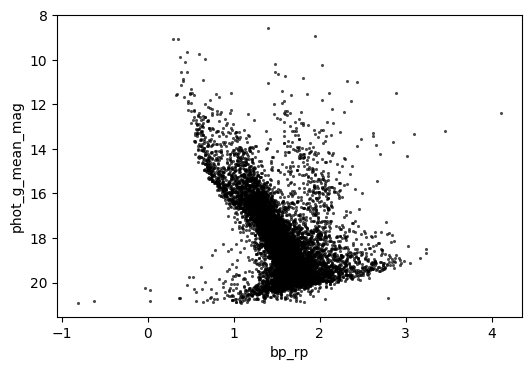

In [6]:
cmd_plot(data=df_NGC_7790_7788, x_axis='bp_rp', y_axis='phot_g_mean_mag', s=5, alpha=.7)

In [7]:
df_NGC_7790_7788.columns

Index(['designation', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ruwe', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
       'radial_velocity', 'phot_variable_flag', 'l', 'b', 'non_single_star',
       'has_xp_continuous', 'has_xp_sampled', 'has_rvs',
       'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
       'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot'],
      dtype='object')

In [8]:
len(df_NGC_7790_7788)

9137

In [9]:
new_cluster["init_data"] = len(df_NGC_7790_7788)

In [10]:
df_NGC_7790_7788['ra'] = np.where(df_NGC_7790_7788['ra'] < 10, df_NGC_7790_7788['ra'] + 360, df_NGC_7790_7788['ra'])

----

# MST Method


## 1. Initial Filters on Data

In [11]:
df_NGC_7790_7788_init = df_NGC_7790_7788.drop(['ra_error', 'dec_error',
       'pmra_error', 
       'pmdec_error', 'ruwe', 'phot_g_mean_flux_error', 
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'radial_velocity', 'phot_variable_flag', 'non_single_star',
       'has_xp_continuous', 'has_xp_sampled', 'has_rvs',
       'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
       'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot'], axis=1).dropna(axis=0)

df_NGC_7790_7788_init = df_NGC_7790_7788_init[df_NGC_7790_7788_init['parallax_error'] < 0.2]

In [12]:
len(df_NGC_7790_7788_init)

5632

In [13]:
# Initial Filter on PMRA and PMDEC 

def filter_proper_motion(data, pmra, pmdec, d_pmra=2, d_pmdec=2):
    # d_pmra = 3 * d_pmra
    # d_pmdec = 3 * d_pmdec
    return data[(abs(data['pmra'] - pmra) < abs(d_pmra * pmra)) & (abs(data['pmdec'] - pmdec) < abs(d_pmdec * pmdec))]

def filter_parallax(data, parallax, delta = .2):
    return data[(abs(data['parallax'] -  parallax) < abs(delta * parallax))]

# def filter_distance(data, r_med, delta = 100):
#     return data[(abs(data['r_med_geo'] - r_med) < delta)] # r_med_geo

In [14]:
df_NGC_7790_7788_init = filter_proper_motion(df_NGC_7790_7788_init, -3.2, -1.7, .3, .3)
df_NGC_7790_7788_init = filter_parallax(df_NGC_7790_7788_init, 0.29, 0.5)

In [15]:
len(df_NGC_7790_7788_init)

974

In [16]:
new_cluster["init_filter"] = len(df_NGC_7790_7788_init)

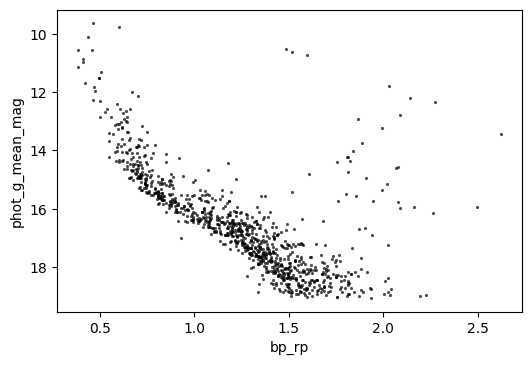

In [17]:
cmd_plot(data = df_NGC_7790_7788_init, x_axis = 'bp_rp', y_axis = 'phot_g_mean_mag', s = 5, alpha = .7)

-----

## 2. MST

In [18]:
params = ['ra', 'dec', 'parallax']

In [19]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_NGC_7790_7788_init[params])

df_scaled = pd.DataFrame(data=x_scaled, columns=params)
df_scaled['source_id'] = df_NGC_7790_7788_init['source_id'].values

threshold: 0.59


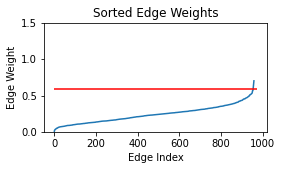

In [20]:
thresh, df_scaled = min_span_tree(df_scaled, params=params, num_std=3, manual_th=0, threshold=0.15, y_limit=1.5, fig=True)

In [21]:
new_cluster["mst_cut"] = thresh

In [22]:
print(len(df_scaled[df_scaled['MST_cluster']==1]))
print(len(df_scaled[df_scaled['MST_cluster']==0]))

693
281


In [23]:
new_cluster["mst_filter"] = len(df_scaled[df_scaled['MST_cluster']==1])

In [24]:
df_NGC_7790_7788_mst = df_NGC_7790_7788_init.merge(df_scaled[["MST_cluster", "source_id"]], on='source_id', how='left')

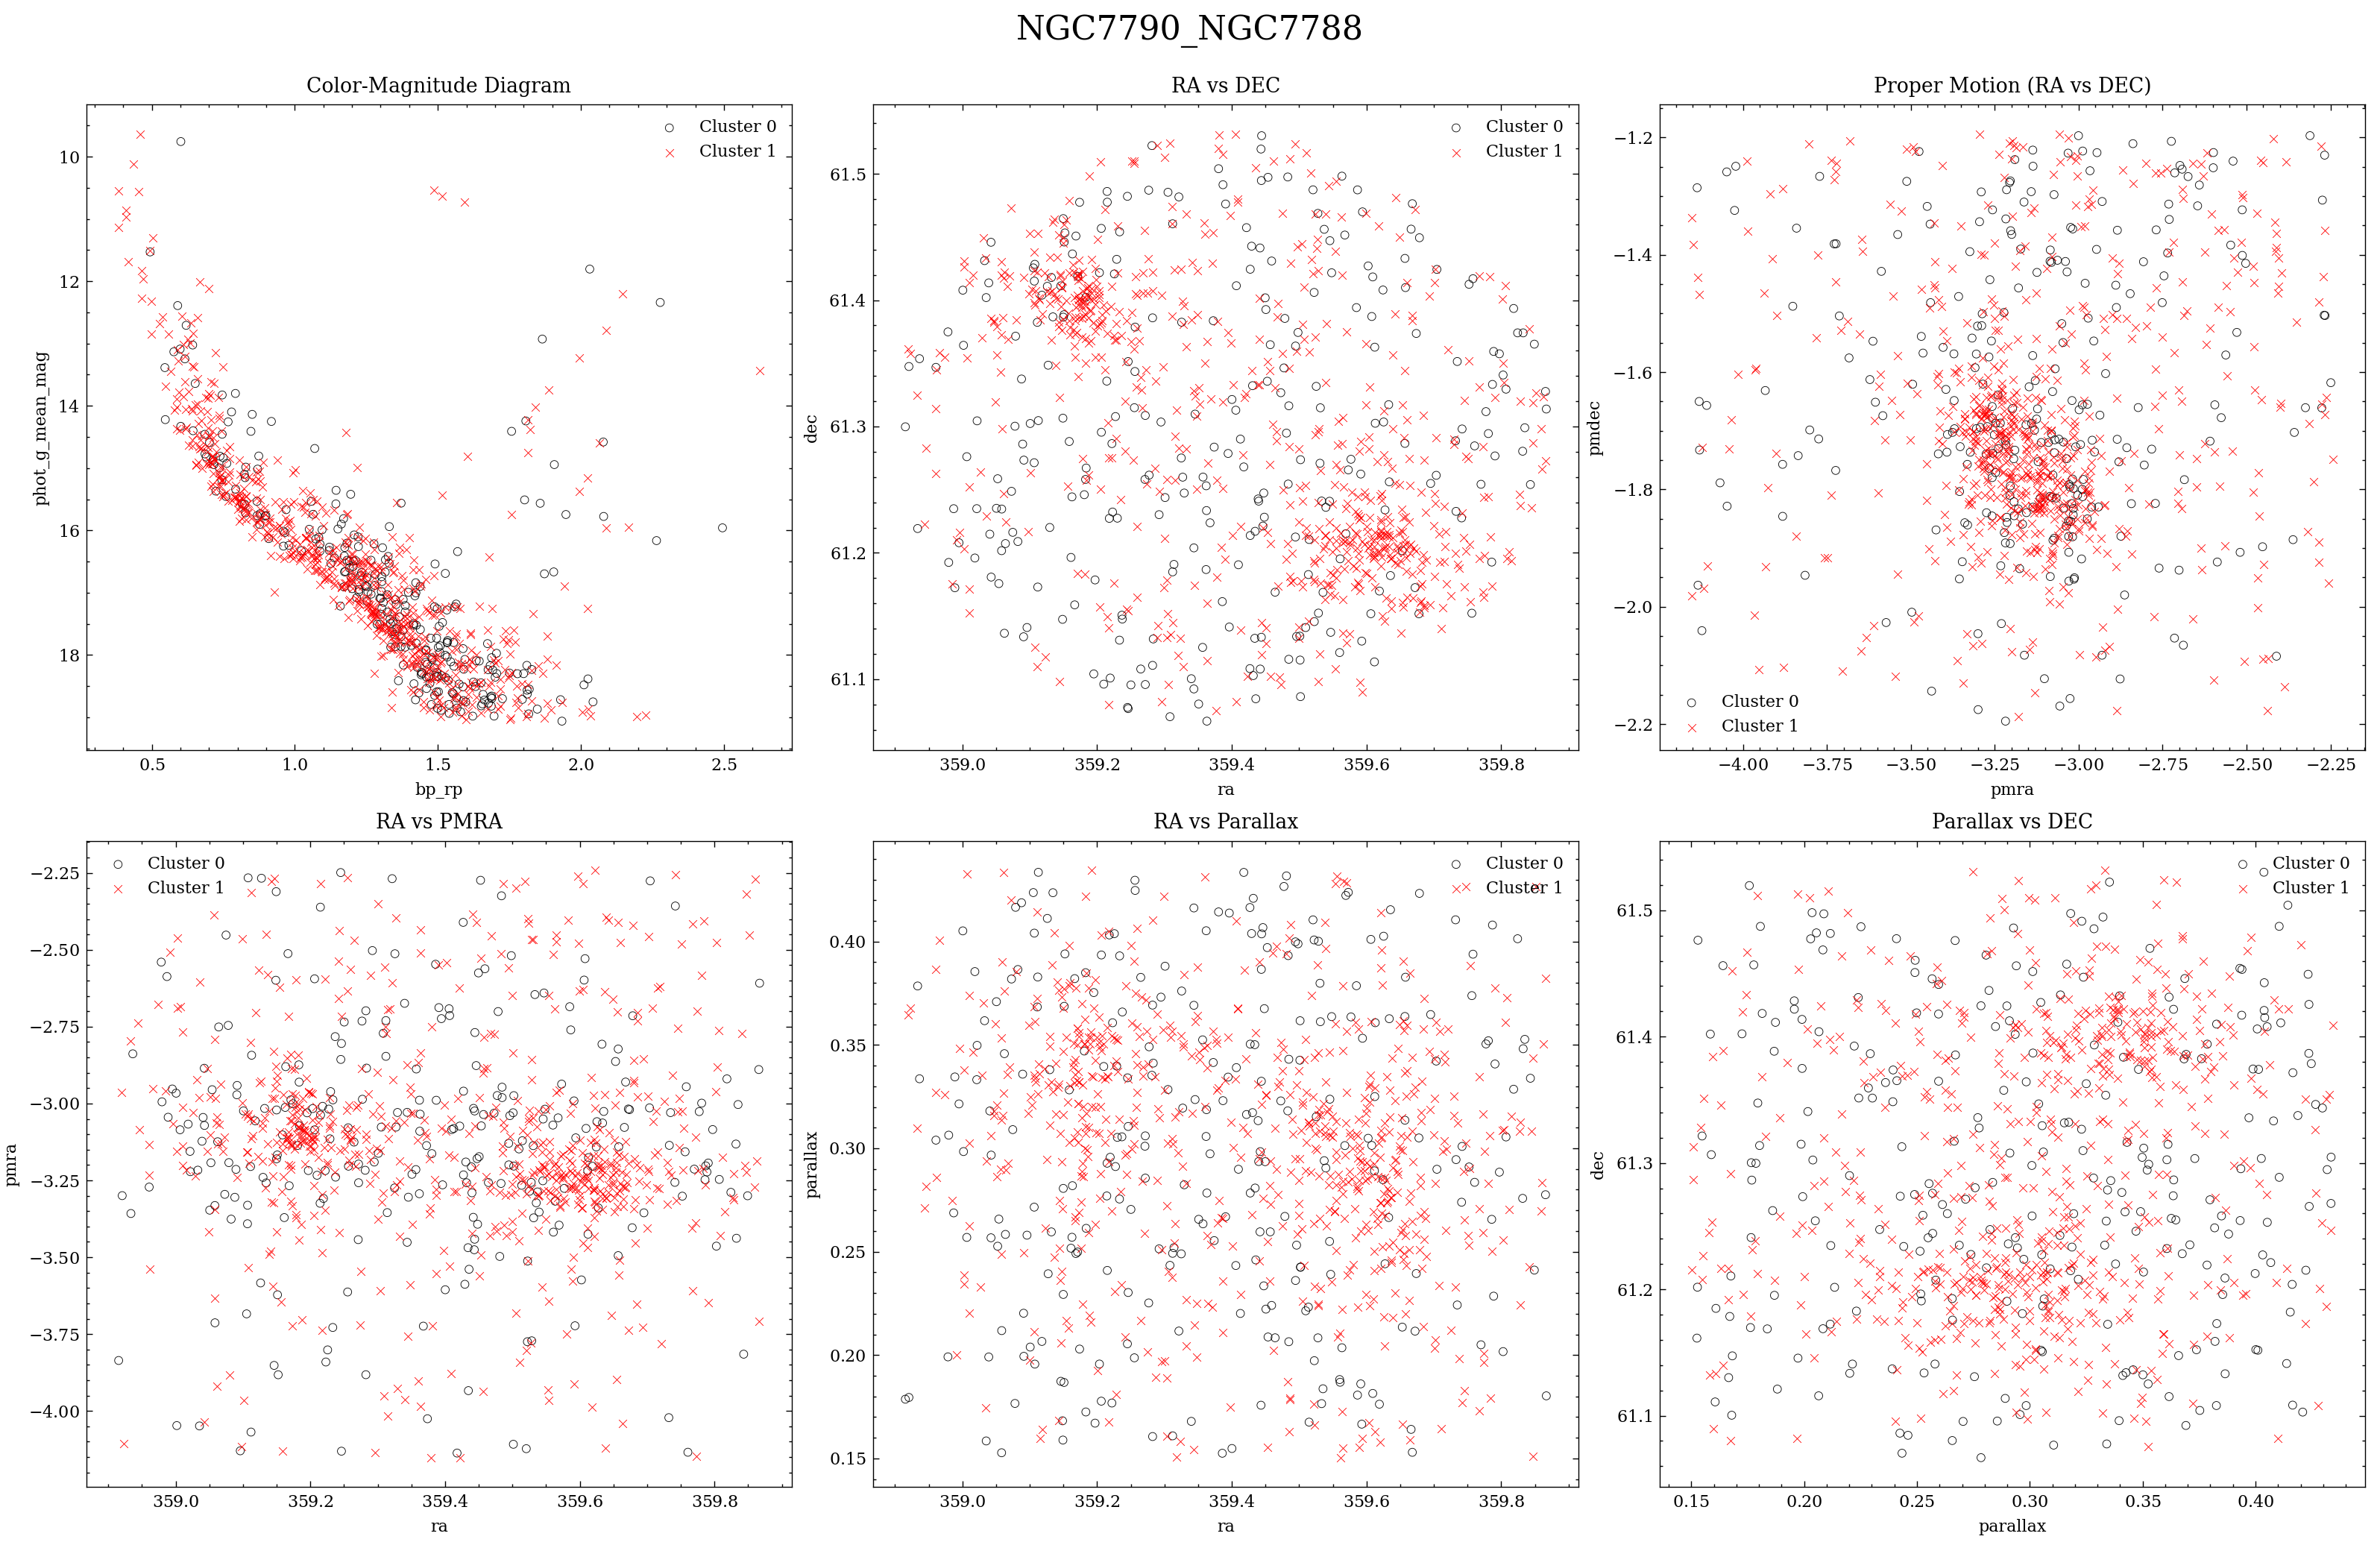

In [25]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=200)

    # First row
    cmd_plotly(df_NGC_7790_7788_mst, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[0, 0], theme={1: 'red', 0: 'black'})
    axes[0, 0].set_title('Color-Magnitude Diagram')

    cmd_plotly(df_NGC_7790_7788_mst, 'ra', 'dec', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[0, 1], theme={1: 'red', 0: 'black'})
    axes[0, 1].invert_yaxis()
    axes[0, 1].set_title('RA vs DEC')

    cmd_plotly(df_NGC_7790_7788_mst, 'pmra', 'pmdec', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[0, 2], theme={1: 'red', 0: 'black'})
    axes[0, 2].invert_yaxis()
    axes[0, 2].set_title('Proper Motion (RA vs DEC)')

    # Second row
    cmd_plotly(df_NGC_7790_7788_mst, 'ra', 'pmra', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[1, 0], theme={1: 'red', 0: 'black'})
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_title('RA vs PMRA')

    cmd_plotly(df_NGC_7790_7788_mst, 'ra', 'parallax', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[1, 1], theme={1: 'red', 0: 'black'})
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_title('RA vs Parallax')

    cmd_plotly(df_NGC_7790_7788_mst, 'parallax', 'dec', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[1, 2], theme={1: 'red', 0: 'black'})
    axes[1, 2].invert_yaxis()
    axes[1, 2].set_title('Parallax vs DEC')

    plt.tight_layout()  
    plt.suptitle("NGC7790_NGC7788", fontsize=16, y=1.03)  
    plt.savefig(path + "/MST_filter.pdf")

#### Statistical Approach (Finding Outliers)

In [26]:
df_NGC_7790_7788_mst = df_NGC_7790_7788_mst[df_NGC_7790_7788_mst['MST_cluster']==1]
df_NGC_7790_7788_mst = df_NGC_7790_7788_mst.reset_index()

In [27]:
scaler = StandardScaler()
temp_df = pd.DataFrame()
to_drop = []

temp_df[['parallax', 'ra', 'dec', 'pmra', 'pmdec']] = scaler.fit_transform(
    df_NGC_7790_7788_mst[['parallax', 'ra', 'dec', 'pmra', 'pmdec']]
)

for i in ['parallax', 'ra', 'dec', 'pmra', 'pmdec']:
    outliers = temp_df[abs(temp_df[i]) > 3].index
    to_drop.extend(outliers)

df_NGC_7790_7788_mst = df_NGC_7790_7788_mst.drop(to_drop)

In [28]:
len(df_NGC_7790_7788_mst)

691

### 3. GMM

In [29]:
def gassian_mixture(data, parameters = ['parallax', 'ra', 'dec']):
    np.random.seed(0)
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[parameters])
    
    gm = GaussianMixture(n_components=3, random_state=0)

    y_pred = gm.fit_predict(x_scaled)
    y_prob = gm.predict_proba(x_scaled)

    data['gmm_pred'] = y_pred
    data['gmm_prob'] = np.amax(y_prob,axis=1)
    return data, gm

In [30]:
# GMM on MST
df_NGC_7790_7788_cluster, model = gassian_mixture(df_NGC_7790_7788_mst)

In [31]:
df_NGC_7790_7788_cluster.gmm_pred.value_counts()

2    312
1    230
0    149
Name: gmm_pred, dtype: int64

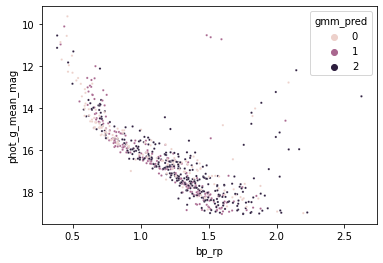

In [32]:
sns.scatterplot(data=df_NGC_7790_7788_cluster, x='bp_rp', y='phot_g_mean_mag', hue='gmm_pred', s=5, alpha=0.99)
plt.gca().invert_yaxis()

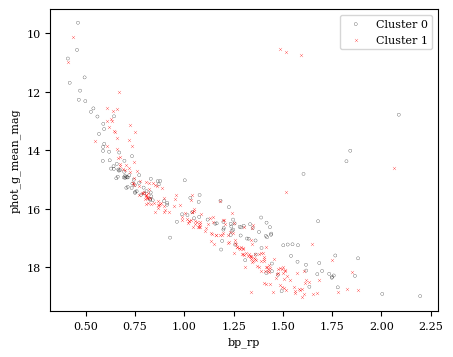

In [33]:
cmd_plotly(df_NGC_7790_7788_cluster, 
           'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=5, alpha=0.99, theme={1:'red', 0:'black'})

In [34]:
num_cluster = 0

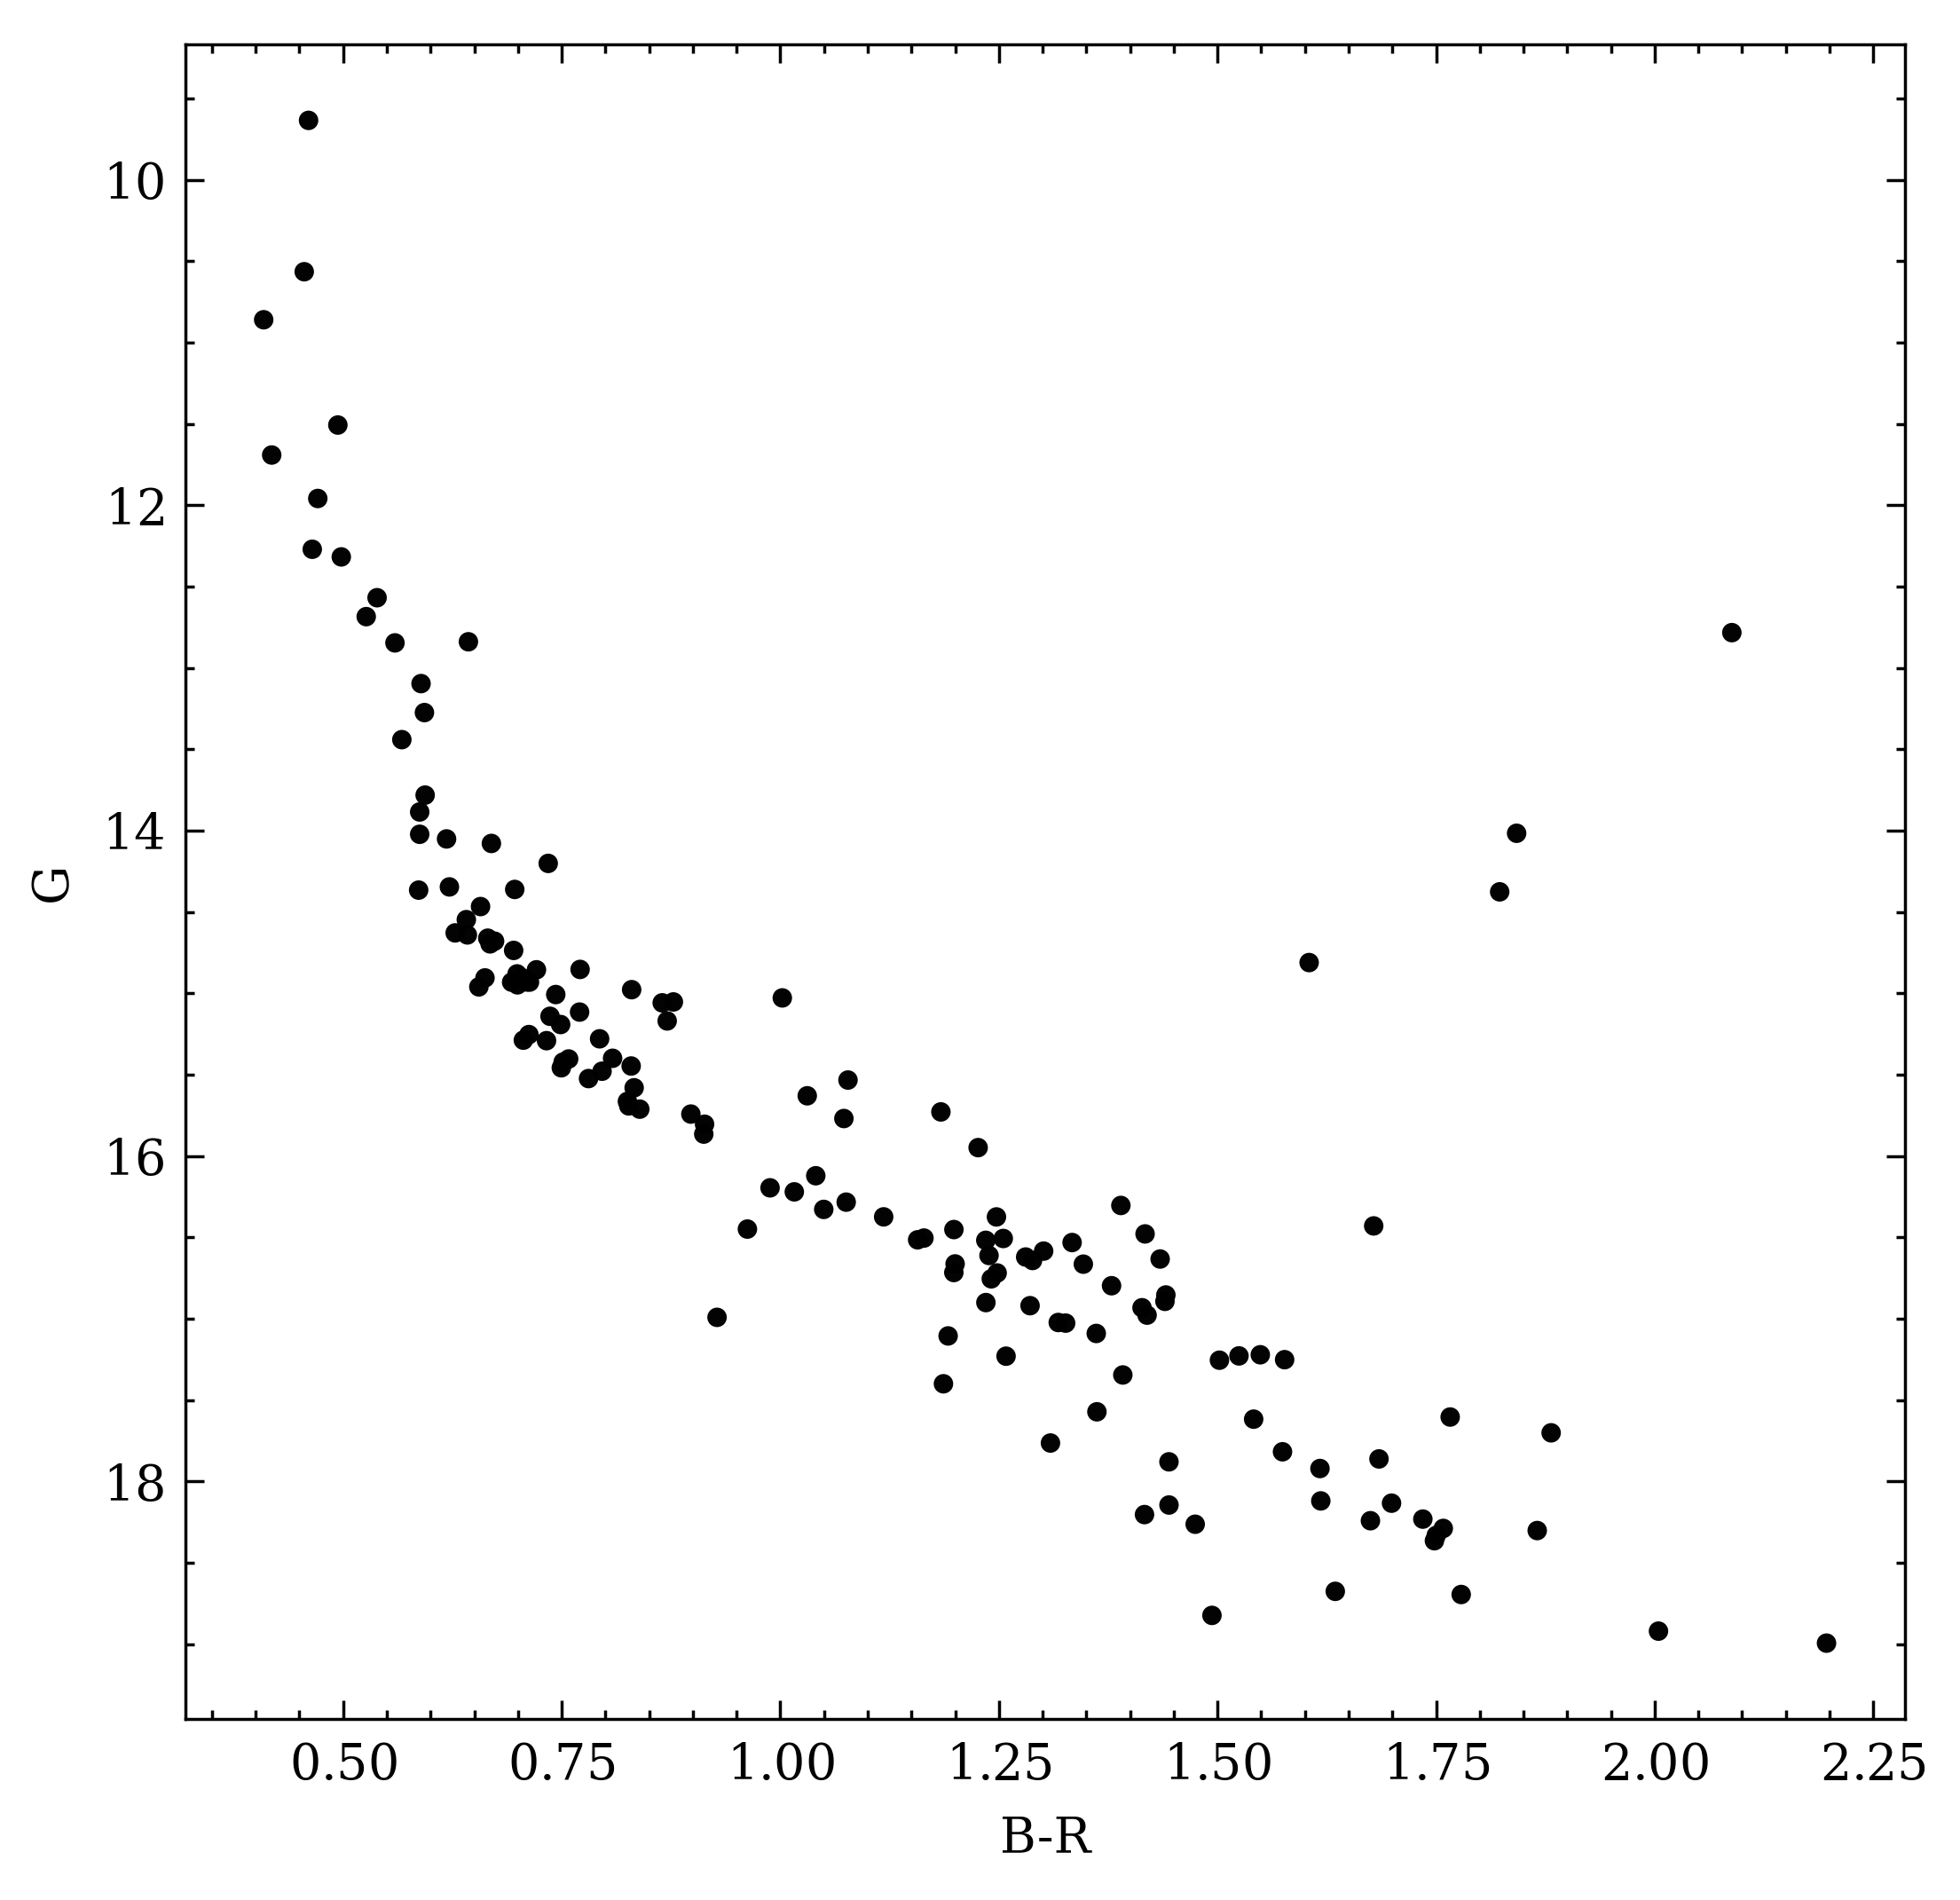

In [35]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    plt.figure(figsize=(5,5), dpi=500)
    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred']==num_cluster], 
           x='bp_rp', y='phot_g_mean_mag', s=10, alpha=.99, lw=0, edgecolor="none")
    plt.xlabel("B-R")
    plt.ylabel("G")
    plt.gca().invert_yaxis()
    plt.savefig(path + "/NGC_7790_7788_cmd_gmm.pdf")
    plt.savefig(path + "/NGC_7790_7788_cmd_gmm.jpg")

In [36]:
### cluster stars

len(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster)])

149

In [37]:
### high probable stars
len(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster) & (df_NGC_7790_7788_cluster['gmm_prob']>=0.8)])

120

In [38]:
new_cluster["gmm_filter"] = len(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster)])

In [39]:
new_cluster["prob_80"] = len(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster) &
                                                 (df_NGC_7790_7788_cluster['gmm_prob']>=0.8)])

## 4. Evaluation

### KDE Plots

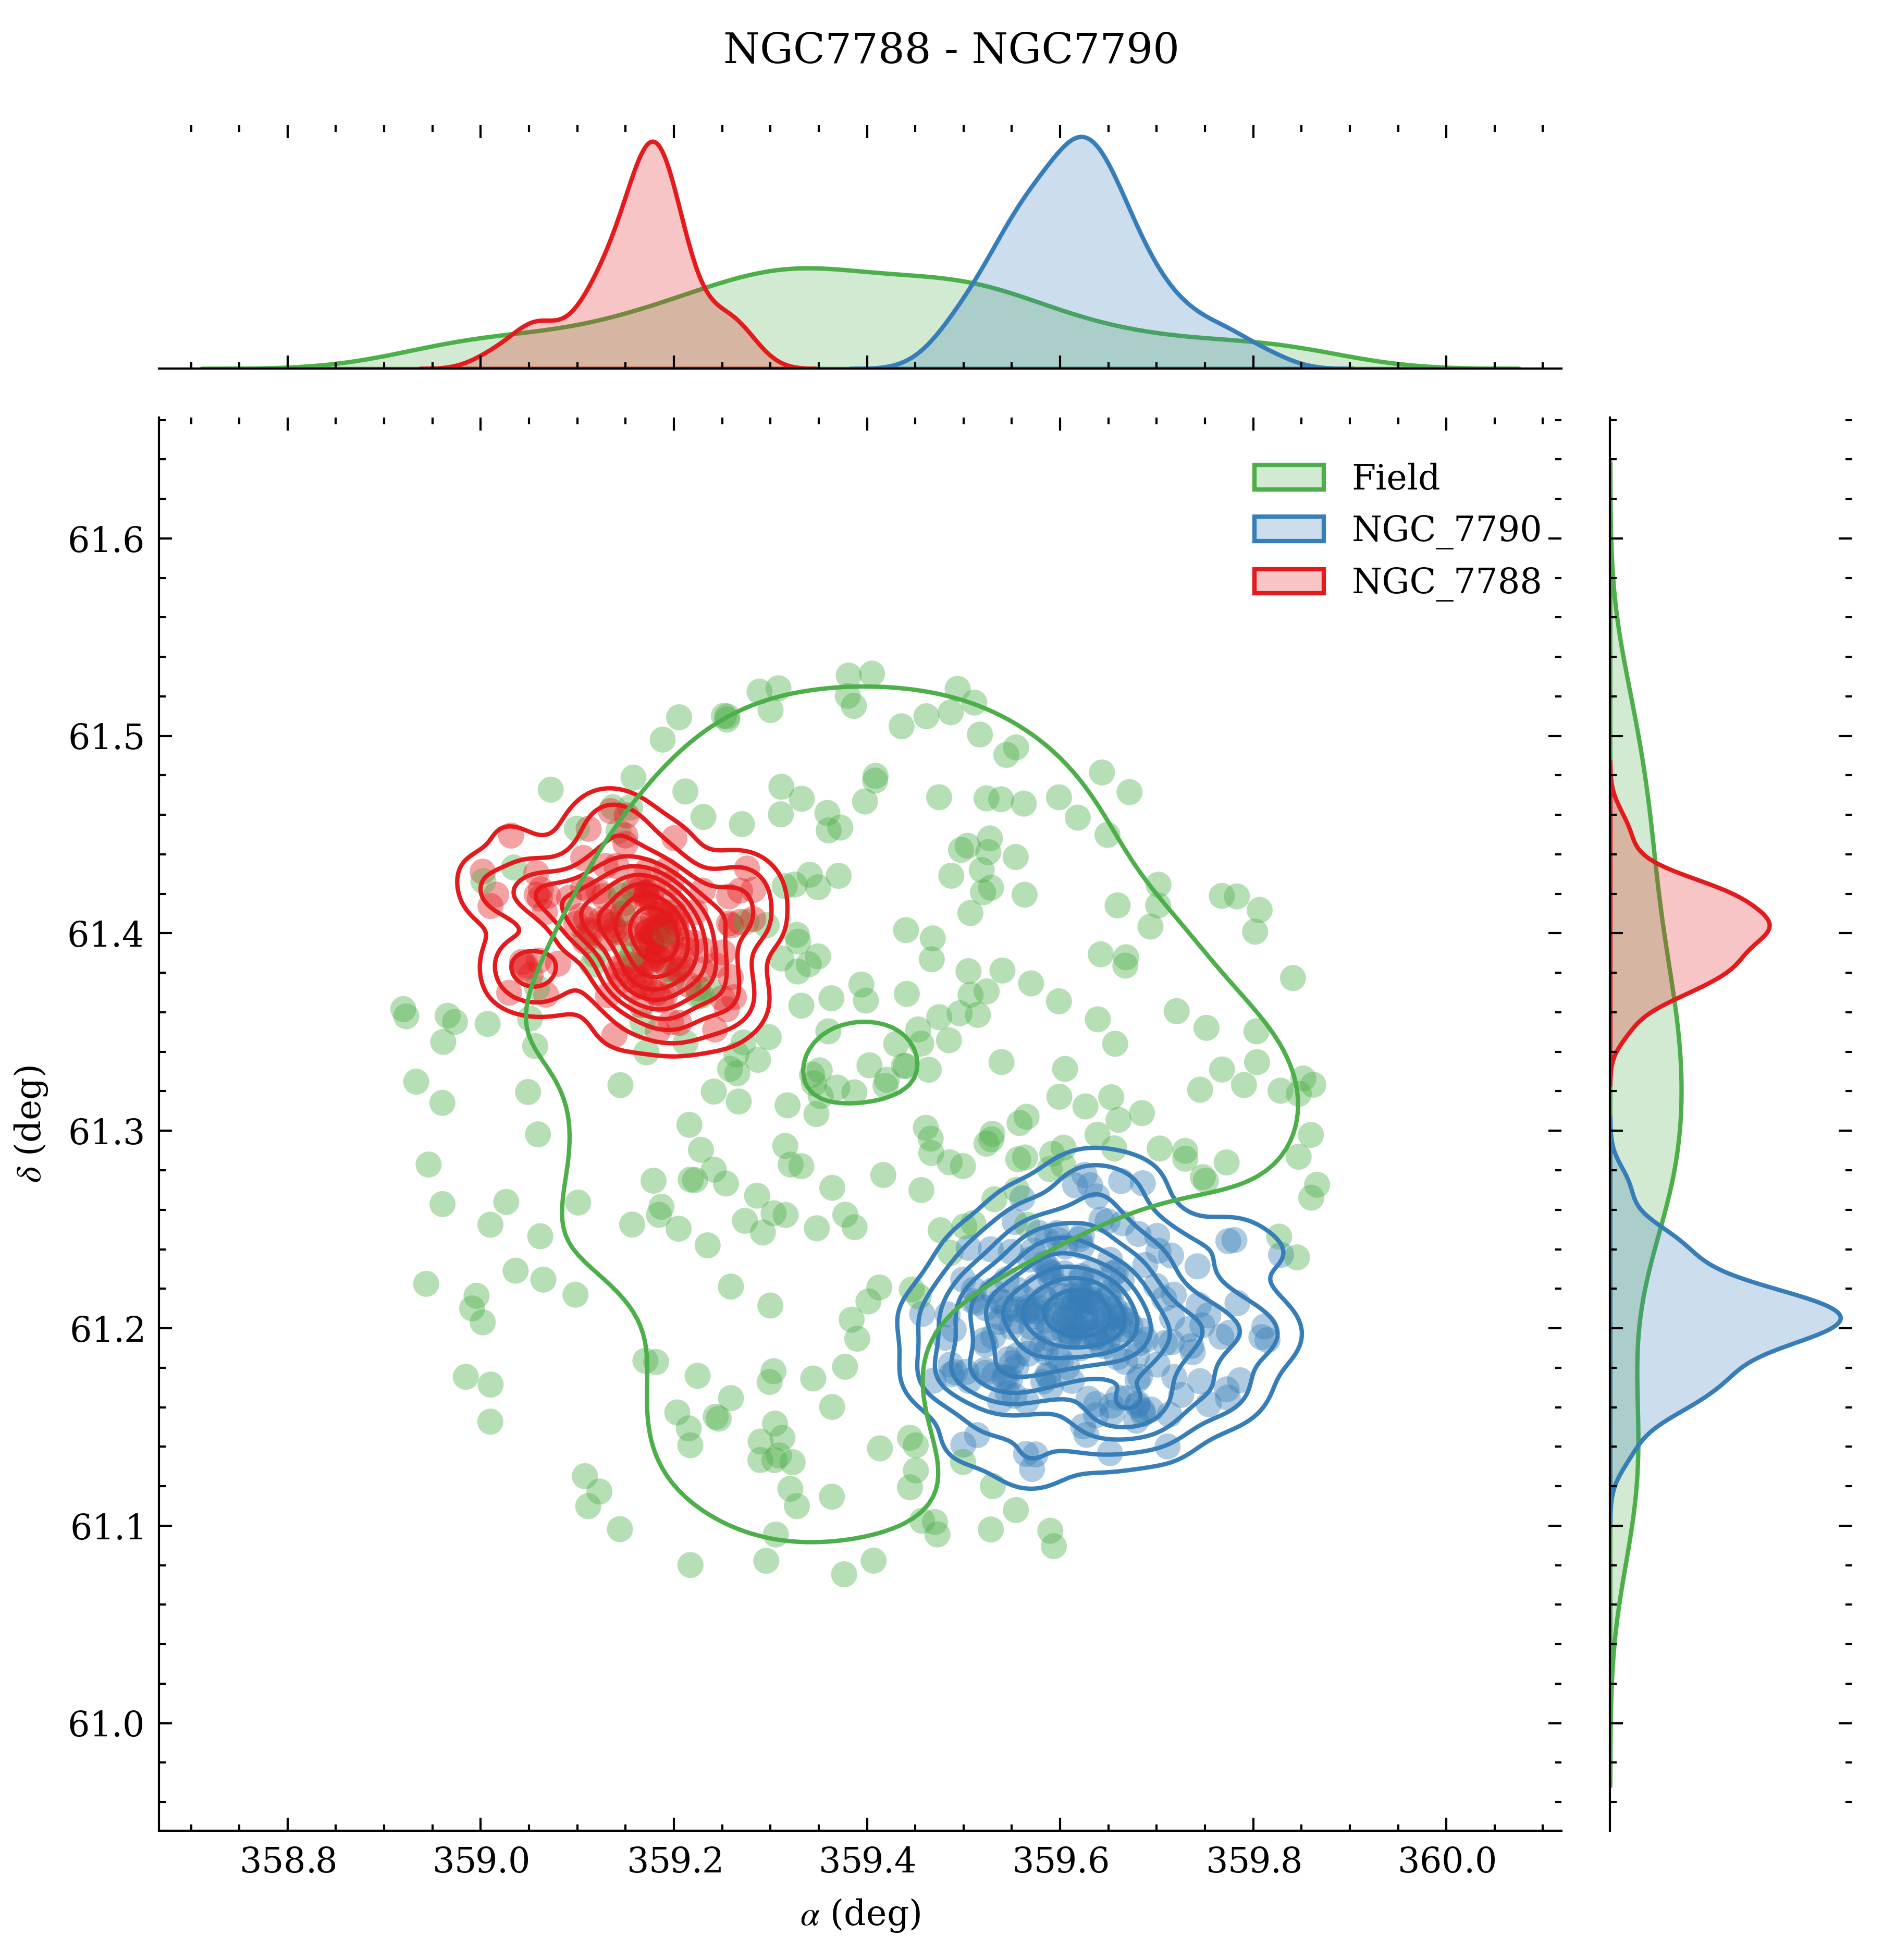

In [40]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    g = sns.jointplot(data=df_NGC_7790_7788_cluster, x='ra', y='dec', kind='scatter', hue='gmm_pred', palette='Set1',
                      alpha=.4, lw=0, edgecolor="none", legend=False)
    # Add a kde plot to the same figure
    sns.kdeplot(data=df_NGC_7790_7788_cluster, x='ra', y='dec', hue='gmm_pred', ax=g.ax_joint,palette='Set1',
                legend=False)
    
    g.ax_joint.set_xlabel(r'$\alpha$ (deg)')
    g.ax_joint.set_ylabel(r'$\delta$ (deg)')
    plt.legend(labels=['Field', 'NGC_7790', 'NGC_7788'], loc='upper right', bbox_to_anchor=(-0.15, 0.99))
    plt.suptitle("NGC7788 - NGC7790", y=1.03)
    plt.savefig(path + "/NGC_7790_7788_kde_scatter.pdf")
    plt.savefig(path + "/NGC_7790_7788_kde_scatter.jpg")

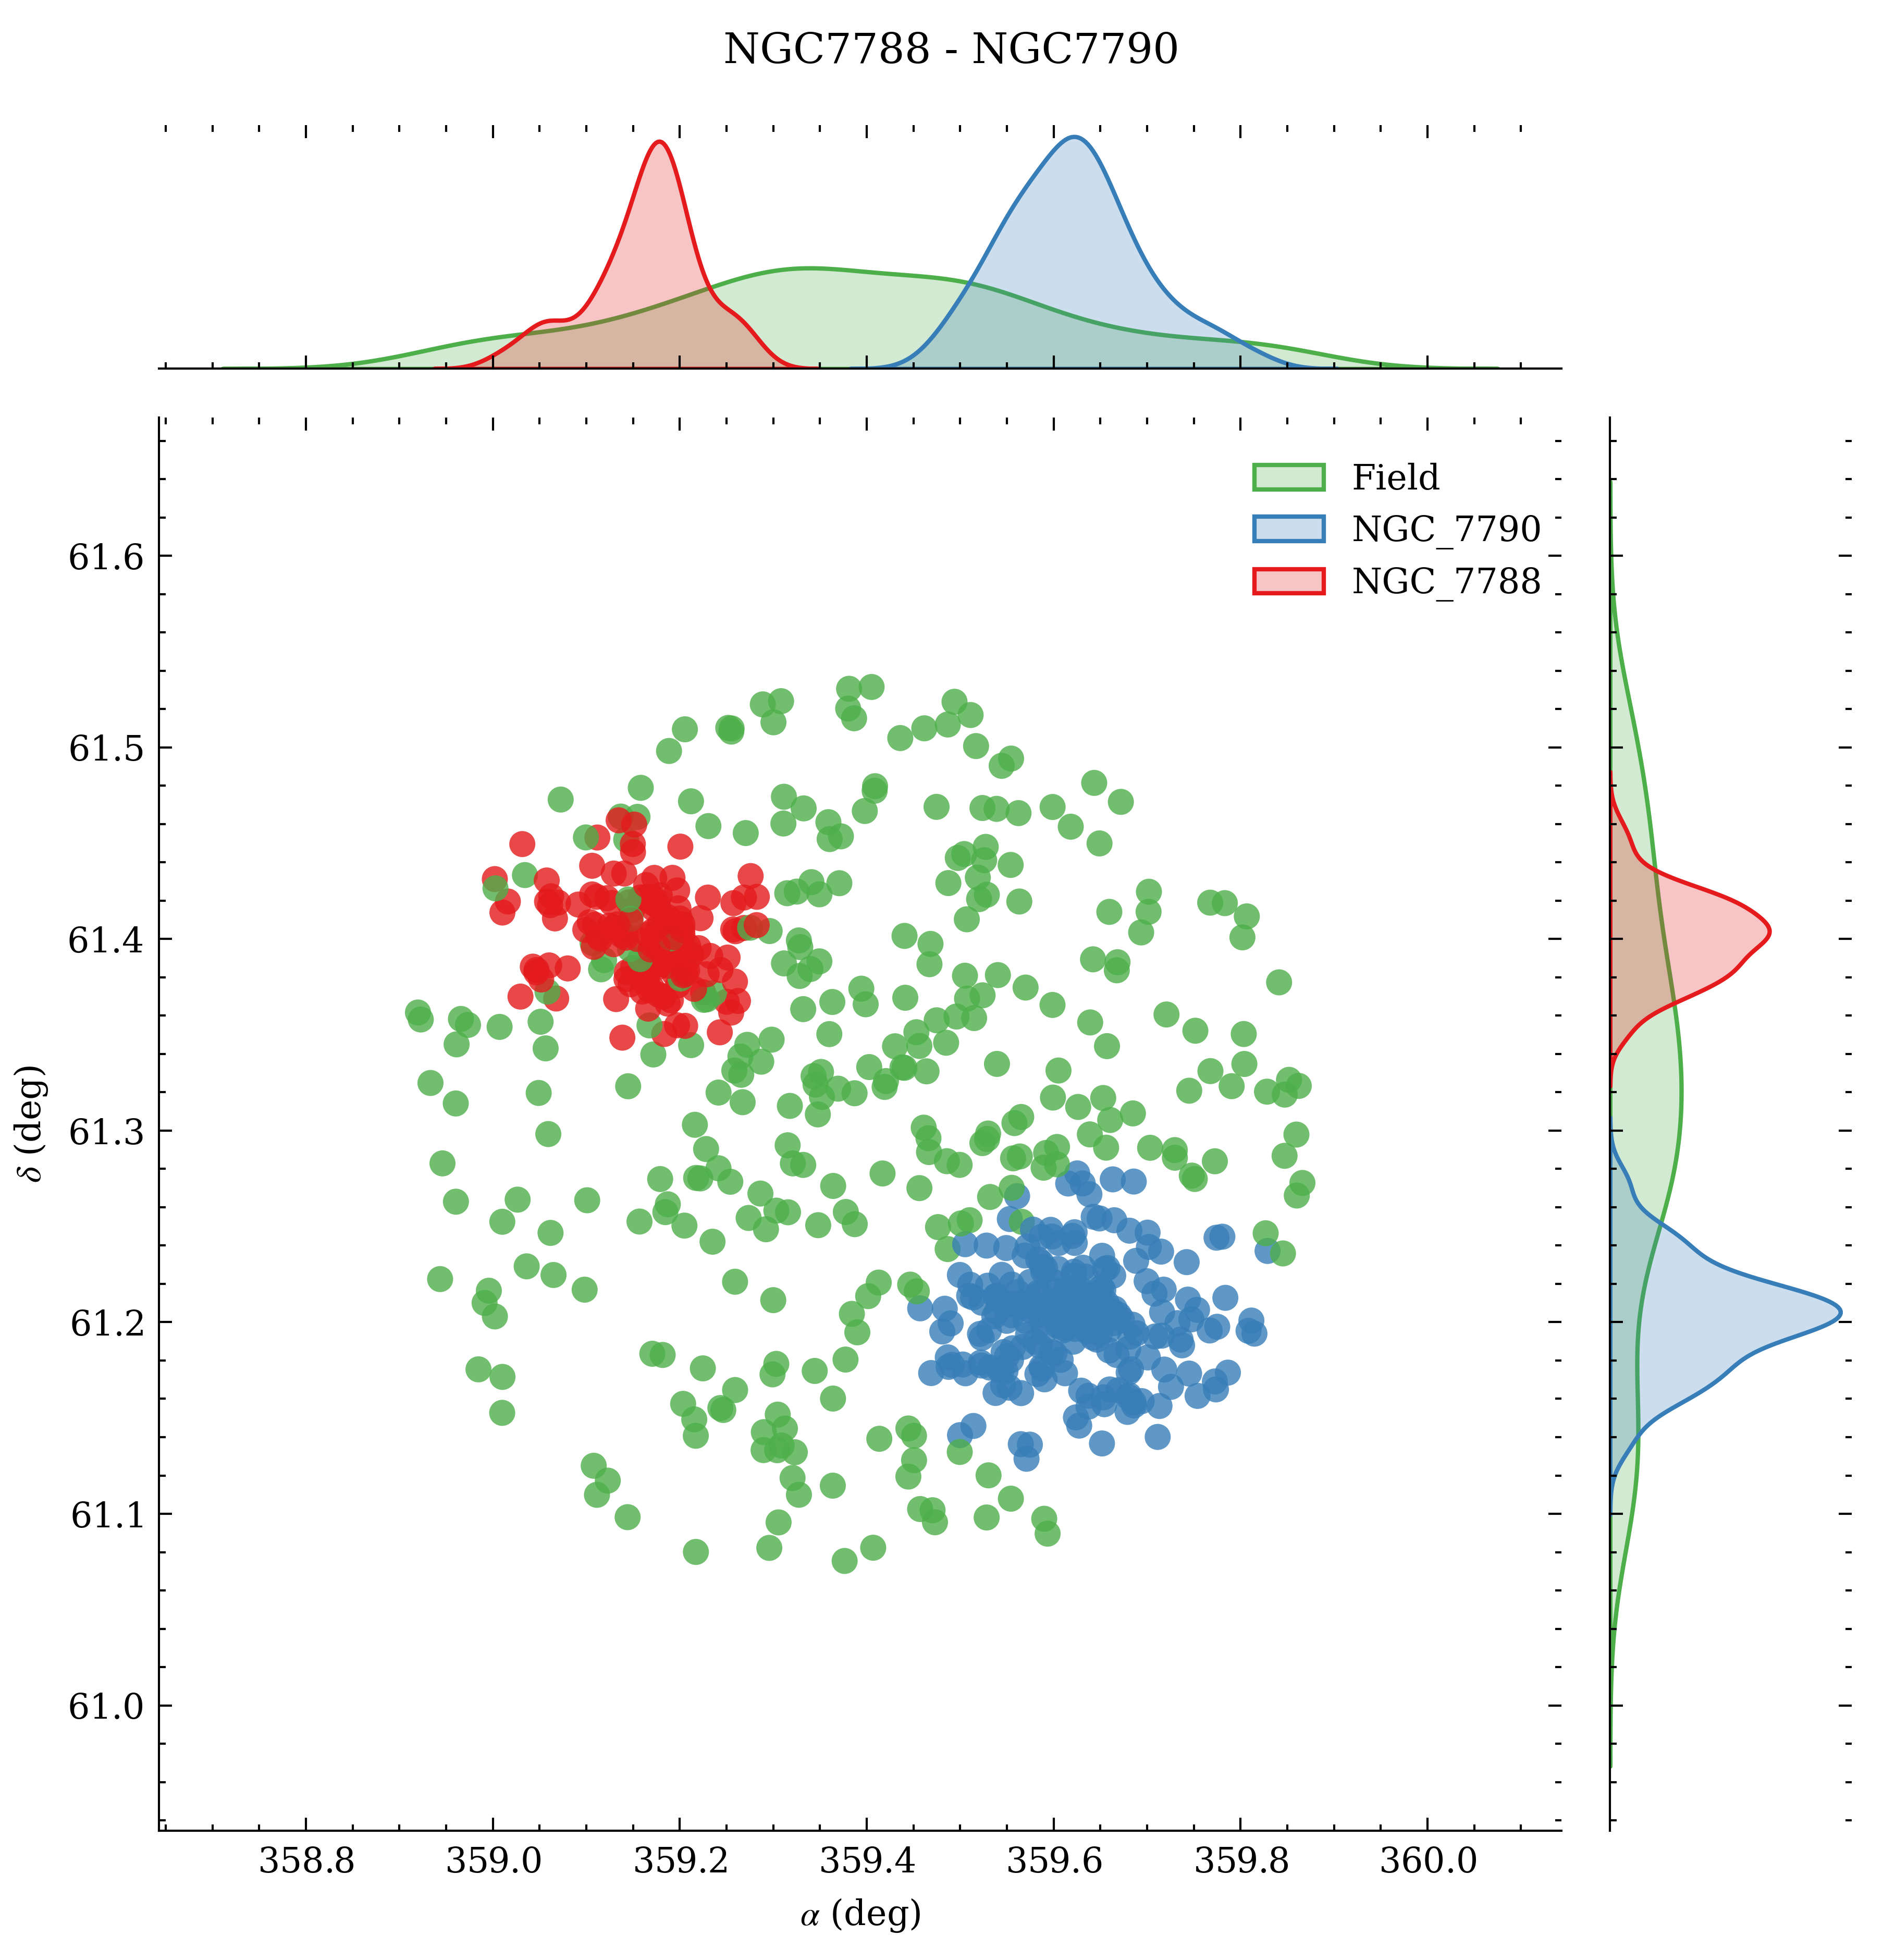

In [41]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    g = sns.jointplot(data=df_NGC_7790_7788_cluster, x='ra', y='dec', kind='scatter', hue='gmm_pred', palette='Set1',
                  alpha=.8, lw=0, edgecolor="none", legend=False)
    
    g.ax_joint.set_xlabel(r'$\alpha$ (deg)')
    g.ax_joint.set_ylabel(r'$\delta$ (deg)')
    plt.legend(labels=['Field', 'NGC_7790', 'NGC_7788'], loc='upper right', bbox_to_anchor=(-0.15, 0.99))
    plt.suptitle("NGC7788 - NGC7790", y=1.03)
    plt.savefig(path + "/NGC_7790_7788_joint_scatter.pdf")
    plt.savefig(path + "/NGC_7790_7788_joint_scatter.jpg")

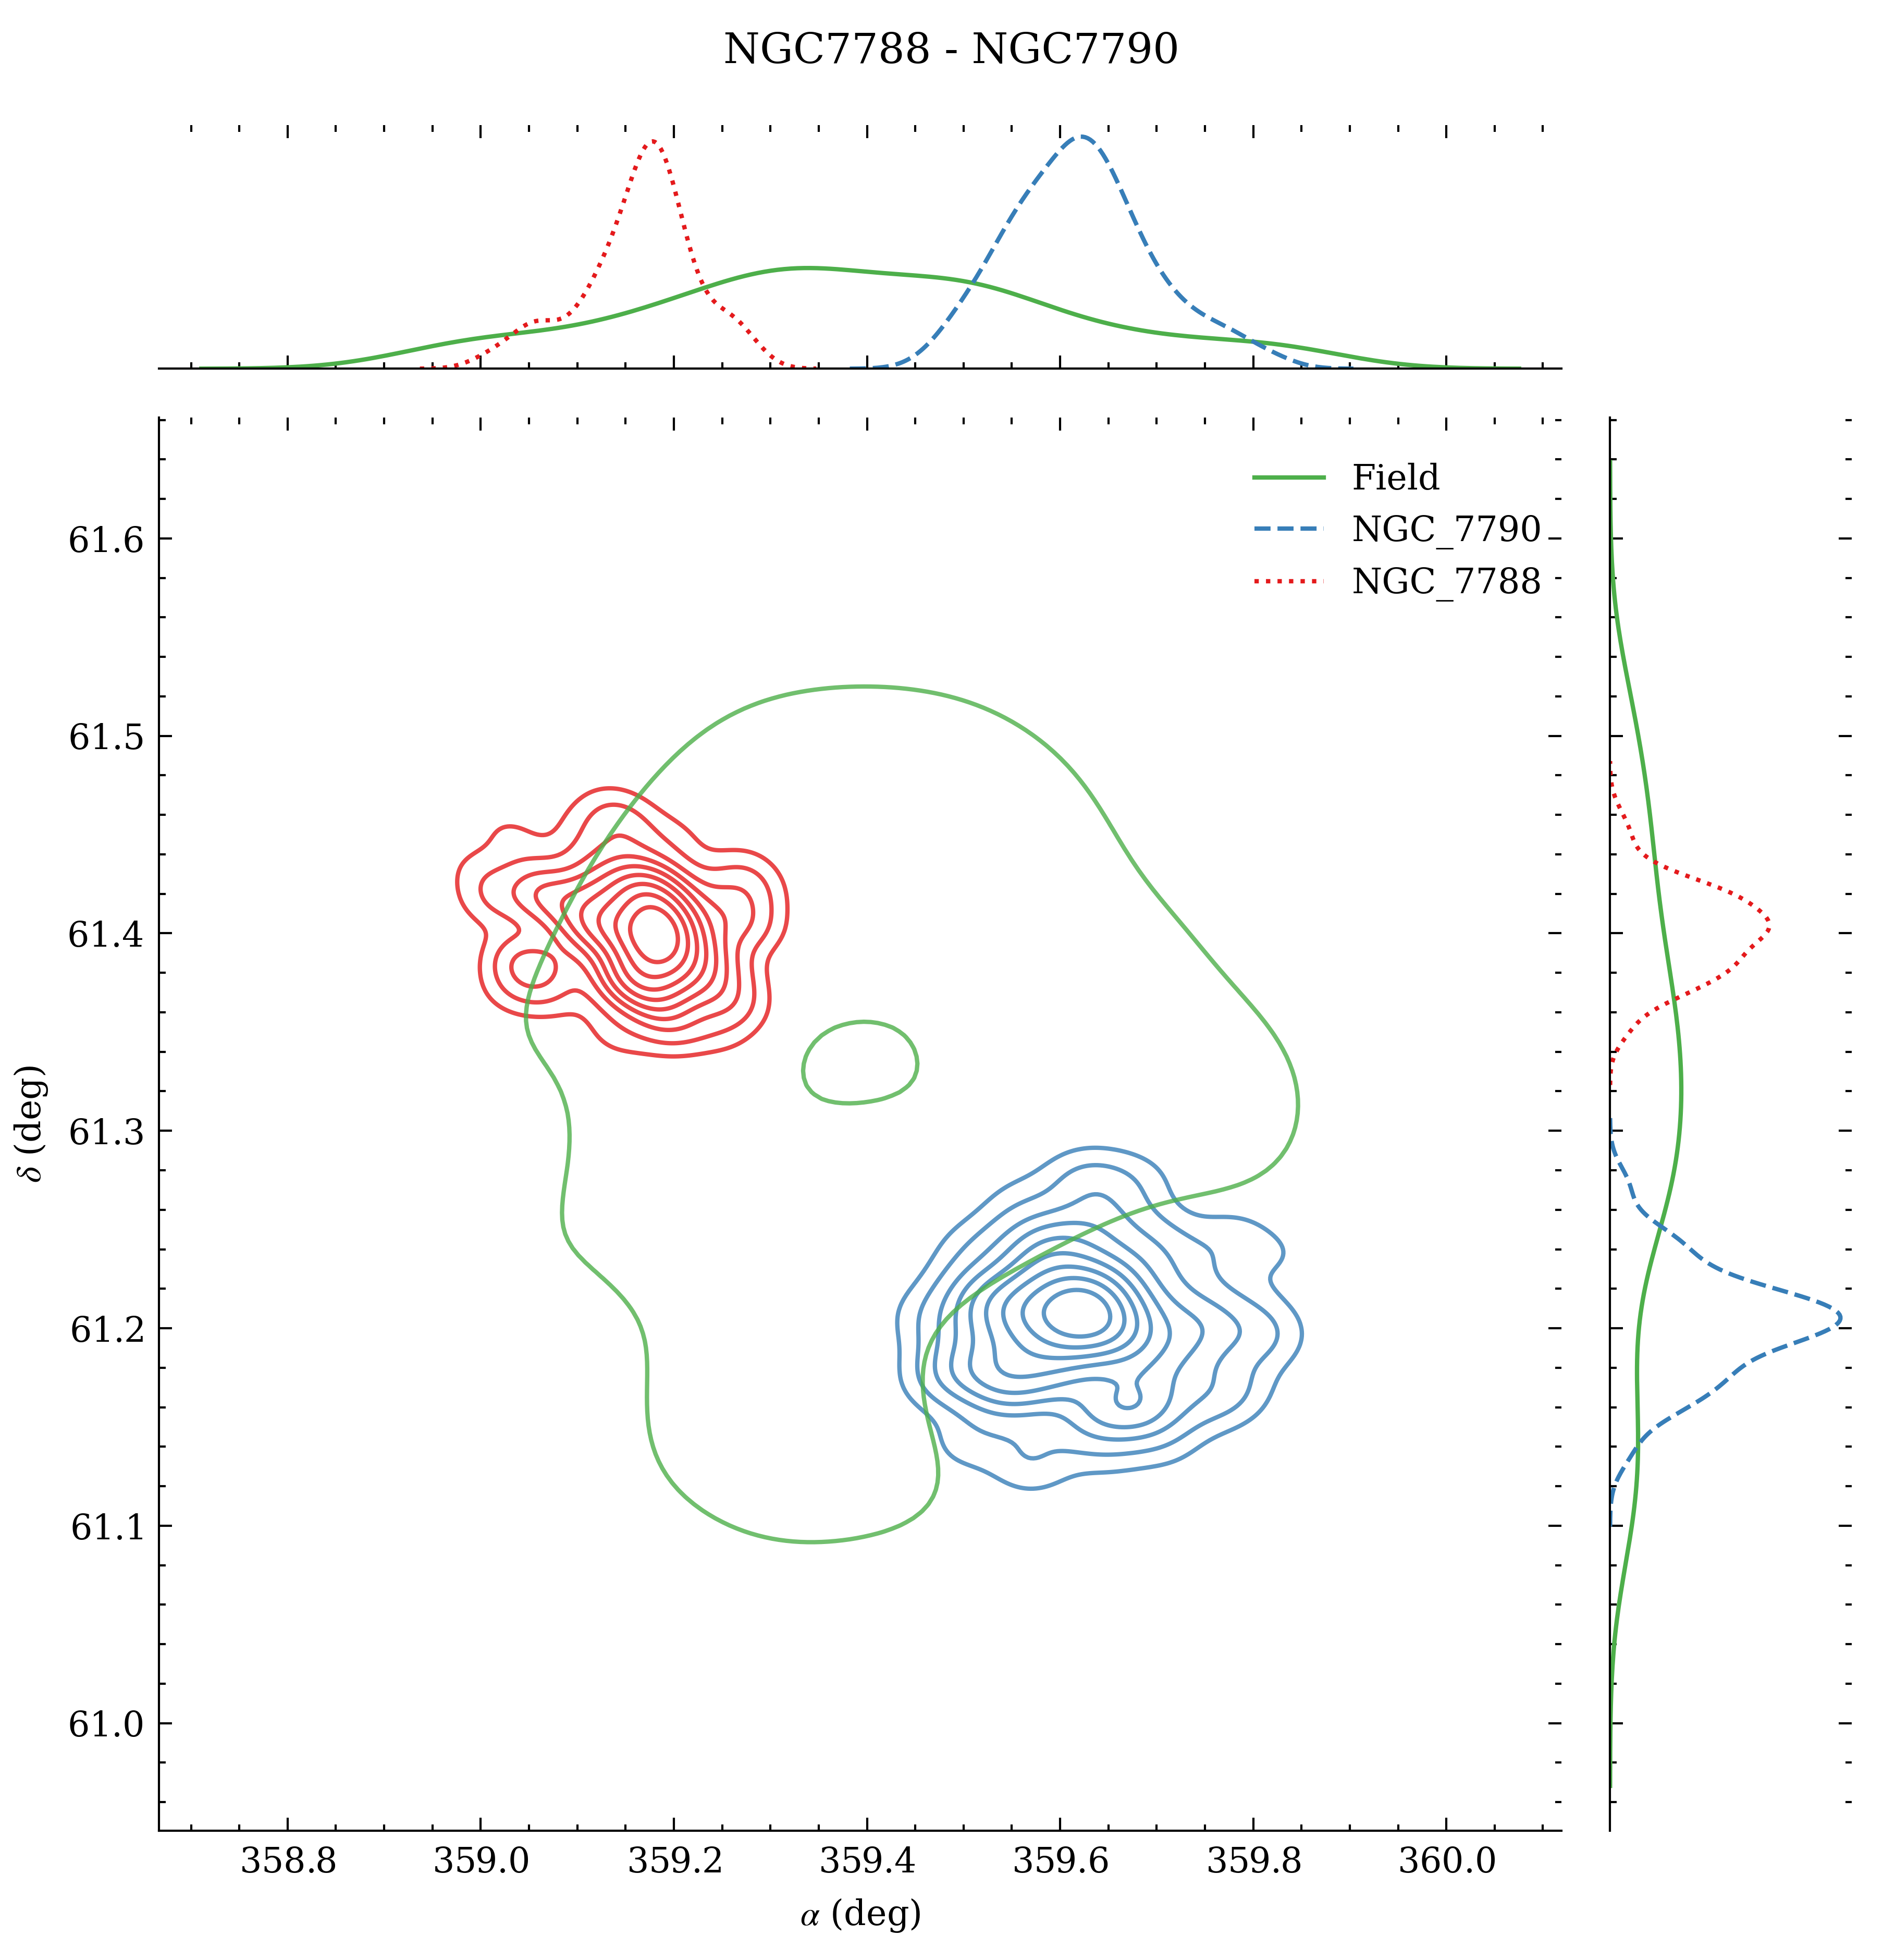

In [42]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    g = sns.jointplot(data=df_NGC_7790_7788_cluster, x='ra', y='dec', kind='kde', hue='gmm_pred', palette='Set1',
                  alpha=.8, lw=0, edgecolor="none", legend=False)
    g.ax_joint.set_xlabel(r'$\alpha$ (deg)')
    g.ax_joint.set_ylabel(r'$\delta$ (deg)')
    plt.legend(labels=['Field', 'NGC_7790', 'NGC_7788'], loc='upper right', bbox_to_anchor=(-0.15, 0.99))
    plt.suptitle("NGC7788 - NGC7790", y=1.03)
    plt.savefig(path + "/NGC_7790_7788_kde.pdf")
    plt.savefig(path + "/NGC_7790_7788_kde.jpg")

In [43]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    
    with plt.style.context(['ieee']):
        if ax is None:
#             fig = plt.figure(figsize=(4,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax, color='black', lw=0, edgecolor="none")
        ax.invert_xaxis()

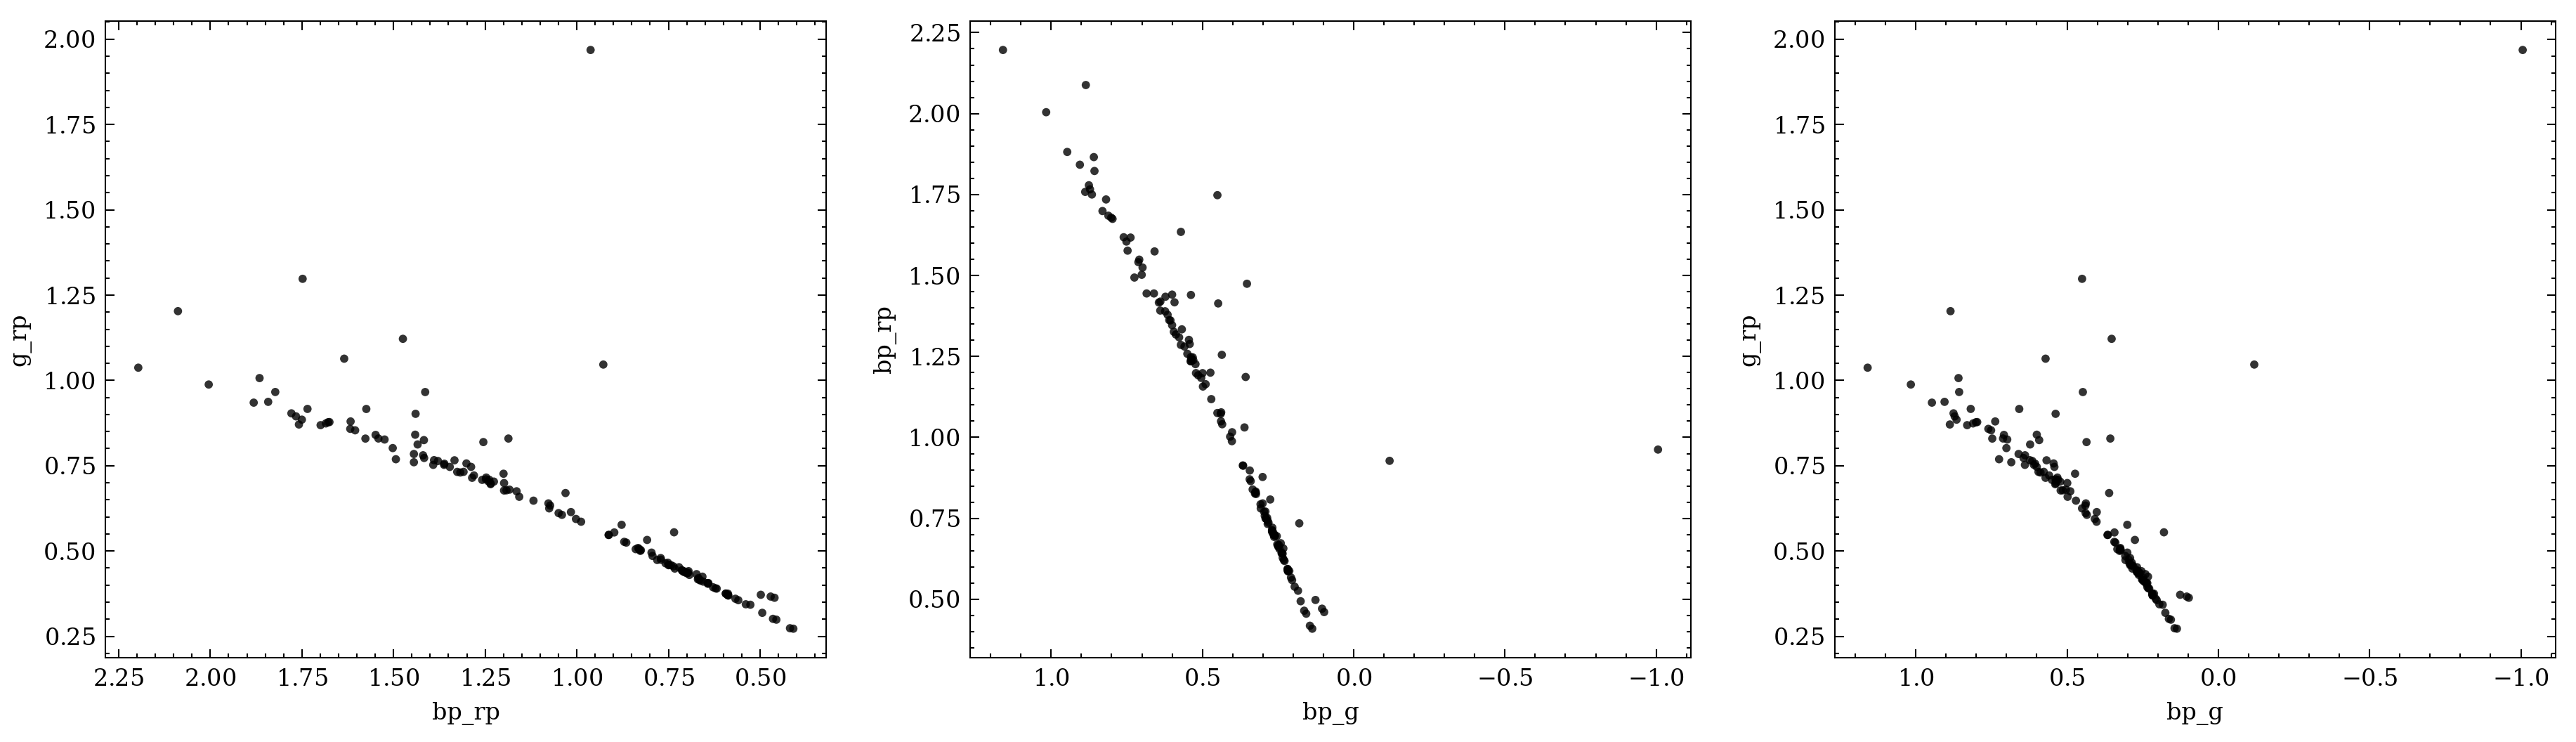

In [44]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=300)
    black_body_plot(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster)], 'bp_rp', 'g_rp', ax=axes[0])
    # black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[0], s=50)

    black_body_plot(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster)], 'bp_g', 'bp_rp', ax=axes[1])
    # black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[1], s=50)

    black_body_plot(df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster)], 'bp_g', 'g_rp', ax=axes[2])
    # black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[2], s=50)
    
    plt.savefig(path+"/NGC_7790_7788_bb.pdf")

### King Profile

In [45]:
cluster = df_NGC_7790_7788_cluster[(df_NGC_7790_7788_cluster['gmm_pred']==num_cluster)]

In [46]:
new_cluster["ra"], new_cluster["dec"], new_cluster["pmra"], new_cluster["pmdec"], new_cluster["plx"]  = \
np.mean(cluster['ra']), np.mean(cluster['dec']), np.mean(cluster['pmra']), np.mean(cluster['pmdec']), np.mean(cluster['parallax'])

In [47]:
new_cluster

{'Name': 'NGC_7790_7788',
 'init_data': 9137,
 'init_filter': 974,
 'mst_cut': 0.59,
 'mst_filter': 693,
 'gmm_filter': 149,
 'pmra': -3.1175170137299335,
 'pmdec': -1.7817436052348303,
 'ra': 359.16351004157593,
 'dec': 61.400665339172235,
 'plx': 0.3385670736249372,
 'prob_80': 120,
 'ra_error': 0,
 'dec_error': 0,
 'pmra_error': 0,
 'pmdec_error': 0,
 'plx_error': 0}

In [48]:
galactic_coord = SkyCoord(l=101.12151 * u.deg, b=-21.156262 * u.deg, frame='galactic')

icrs_coord = galactic_coord.transform_to('icrs')

print("RA (ICRS J2000):", icrs_coord.ra.to_string(u.hour))
print("Dec (ICRS J2000):", icrs_coord.dec.to_string(u.degree))

RA (ICRS J2000): 23h08m08.70041581s
Dec (ICRS J2000): 37d18m07.97110594s


In [49]:
np.mean(cluster['ra']), np.mean(cluster['dec'])

(359.16351004157593, 61.400665339172235)

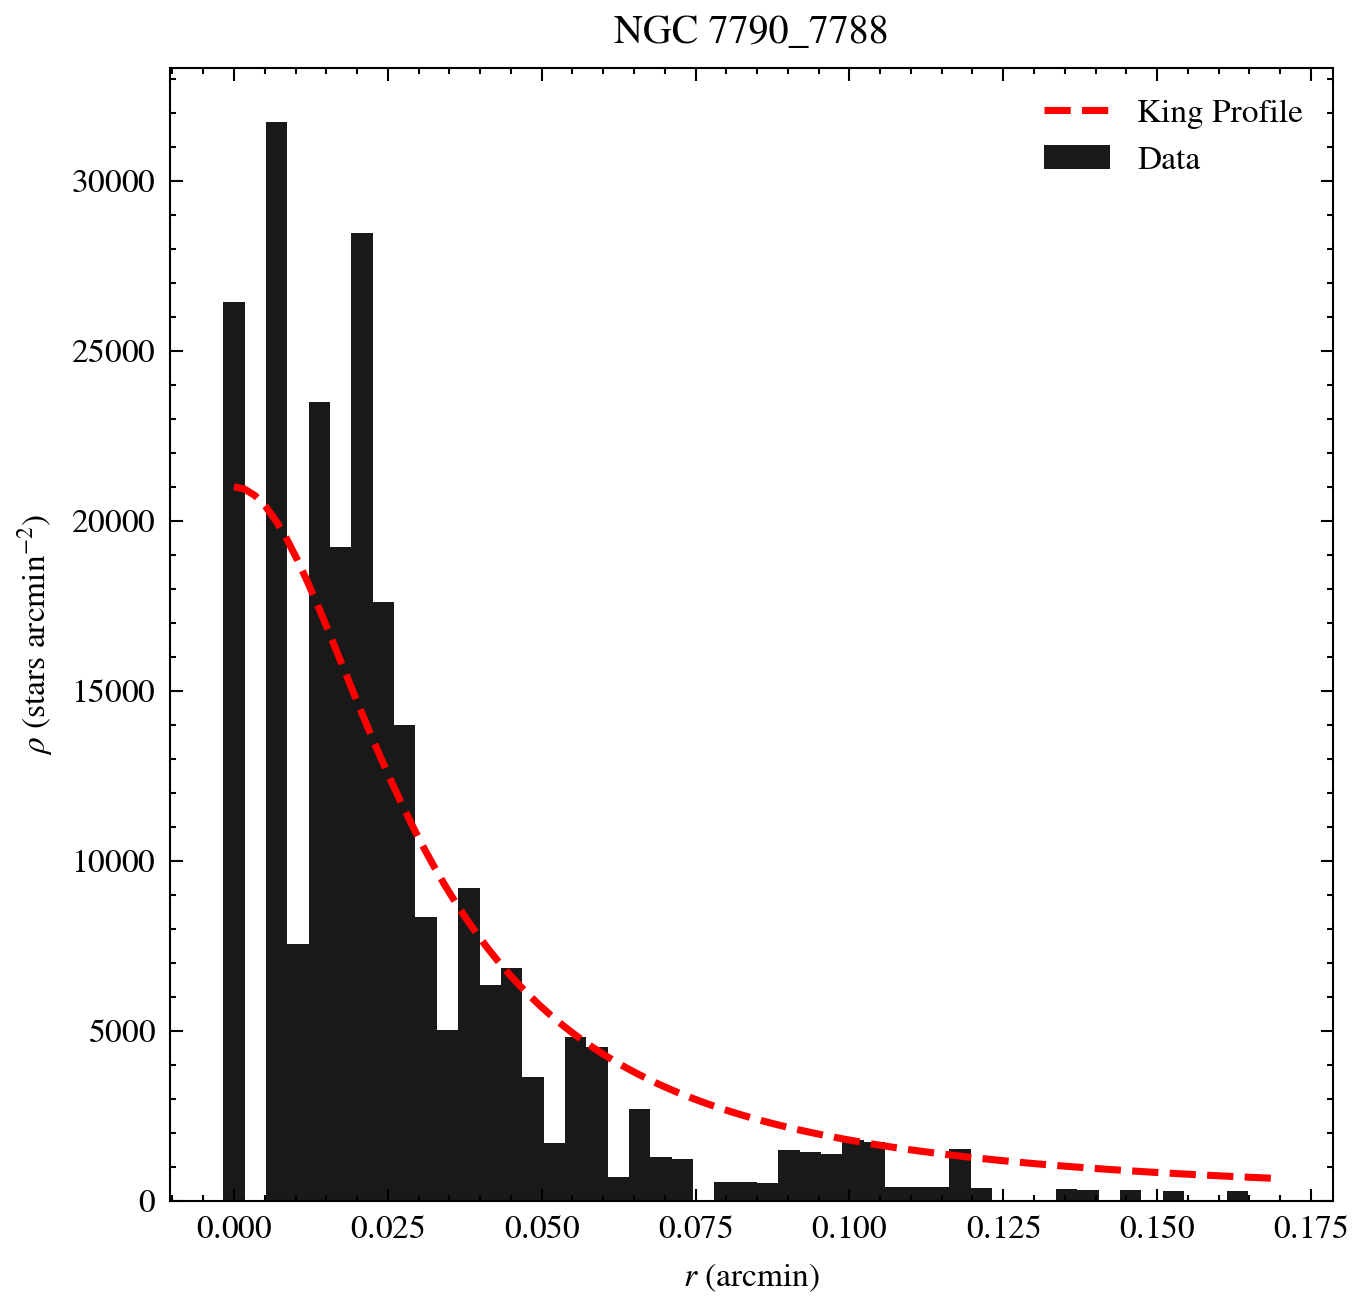

NGC 7790_7788
f_b: 0.0 std: 1291.51
f_0: 21008.92
R_c: 0.03
R_t: 0.06


In [51]:
# Fit the King profile
coefs, R_t, cov = fit_king_profile(cluster, path=path, radius_num=50, cluster_name="NGC 7790_7788")

# Print results
print('NGC 7790_7788')
print("f_b:", round(coefs[0], 2), 'std:', round(np.sqrt(cov[0, 0]), 2))  # Background density and its error
print("f_0:", round(coefs[1], 2))  # Central density above the background
print("R_c:", round(coefs[2], 2))  # Core radius
print("R_t:", round(R_t, 2))  # Tidal radius77

In [52]:
# Core radius error
err_Rc = np.sqrt(cov[2, 2])  # Standard deviation of R_c
print("Err Rc:", round(err_Rc, 5))

# Tidal radius error calculation
err_Rt = (coefs[2] + err_Rc) * np.sqrt(coefs[1] / (3 * np.sqrt(cov[0, 0])) - 1)
print("Err Rt:", round(err_Rt, 5))

Err Rc: 0.00726
Err Rt: 0.0794


In [53]:
# Center of the cluster
center = (np.mean(cluster['ra']), np.mean(cluster['dec']))
distances = np.sqrt((cluster['ra'] - center[0])**2 + (cluster['dec'] - center[1])**2)

# Stars within core radius
stars_within_core = cluster[(distances < coefs[2])]
print(f"Stars within core radius: {len(stars_within_core)}")

# Stars outside tidal radius
stars_out_of_bound = cluster[(distances > R_t)]
print(f"Stars outside tidal radius: {len(stars_out_of_bound)}")

Stars within core radius: 57
Stars outside tidal radius: 42


In [64]:
# df_NGC_7790_7788_cluster = df_NGC_7790_7788_cluster.merge(
#     df_NGC_7790_7788[["SOURCE_ID", "r_med_geo"]], on='source_id', how='left').drop("index", axis=1)

### Final Plots

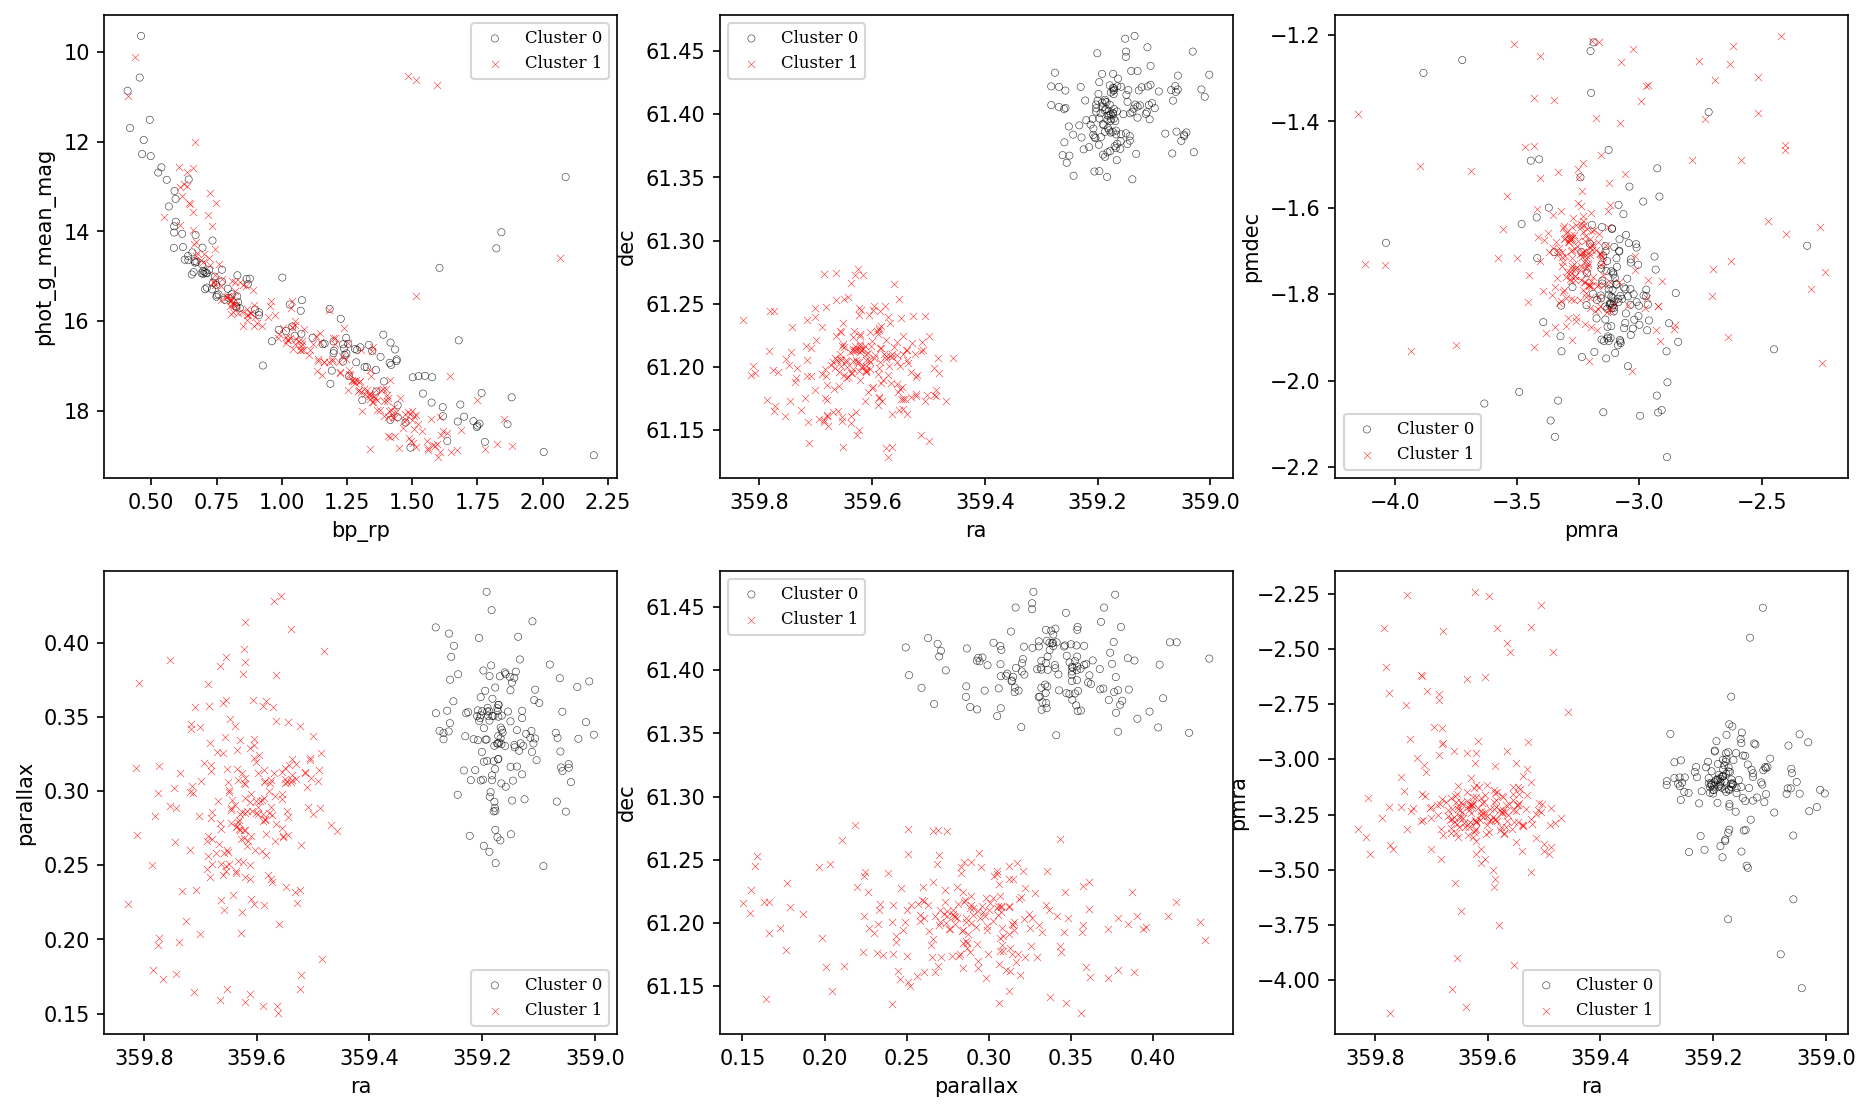

In [54]:
### PLOT THE CLUSTERS

fig, axes = plt.subplots(2, 3, figsize=(15, 9), dpi=150)

cmd_plotly(df_NGC_7790_7788_cluster, 'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,0], theme={1:'red', 0:'black'})
cmd_plotly(df_NGC_7790_7788_cluster, 'ra', 'dec', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,1], theme={1:'red', 0:'black'})
axes[0,1].invert_yaxis()
axes[0,1].invert_xaxis()
cmd_plotly(df_NGC_7790_7788_cluster, 'ra', 'parallax', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,0], theme={1:'red', 0:'black'})
axes[1,0].invert_yaxis()
axes[1,0].invert_xaxis()
cmd_plotly(df_NGC_7790_7788_cluster, 'parallax', 'dec', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,1], theme={1:'red', 0:'black'})
axes[1,1].invert_yaxis()
cmd_plotly(df_NGC_7790_7788_cluster, 'pmra', 'pmdec', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,2], theme={1:'red', 0:'black'})
axes[0,2].invert_yaxis()
cmd_plotly(df_NGC_7790_7788_cluster, 'ra', 'pmra', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,2], theme={1:'red', 0:'black'})
axes[1,2].invert_xaxis()
axes[1,2].invert_yaxis()

In [55]:
len(cluster[cluster["gmm_prob"]>=0.99])

0

In [56]:
len(cluster[cluster["gmm_prob"]>=0.6])

138

In [57]:
len(cluster)

149

In [58]:
len(df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster+1])

230

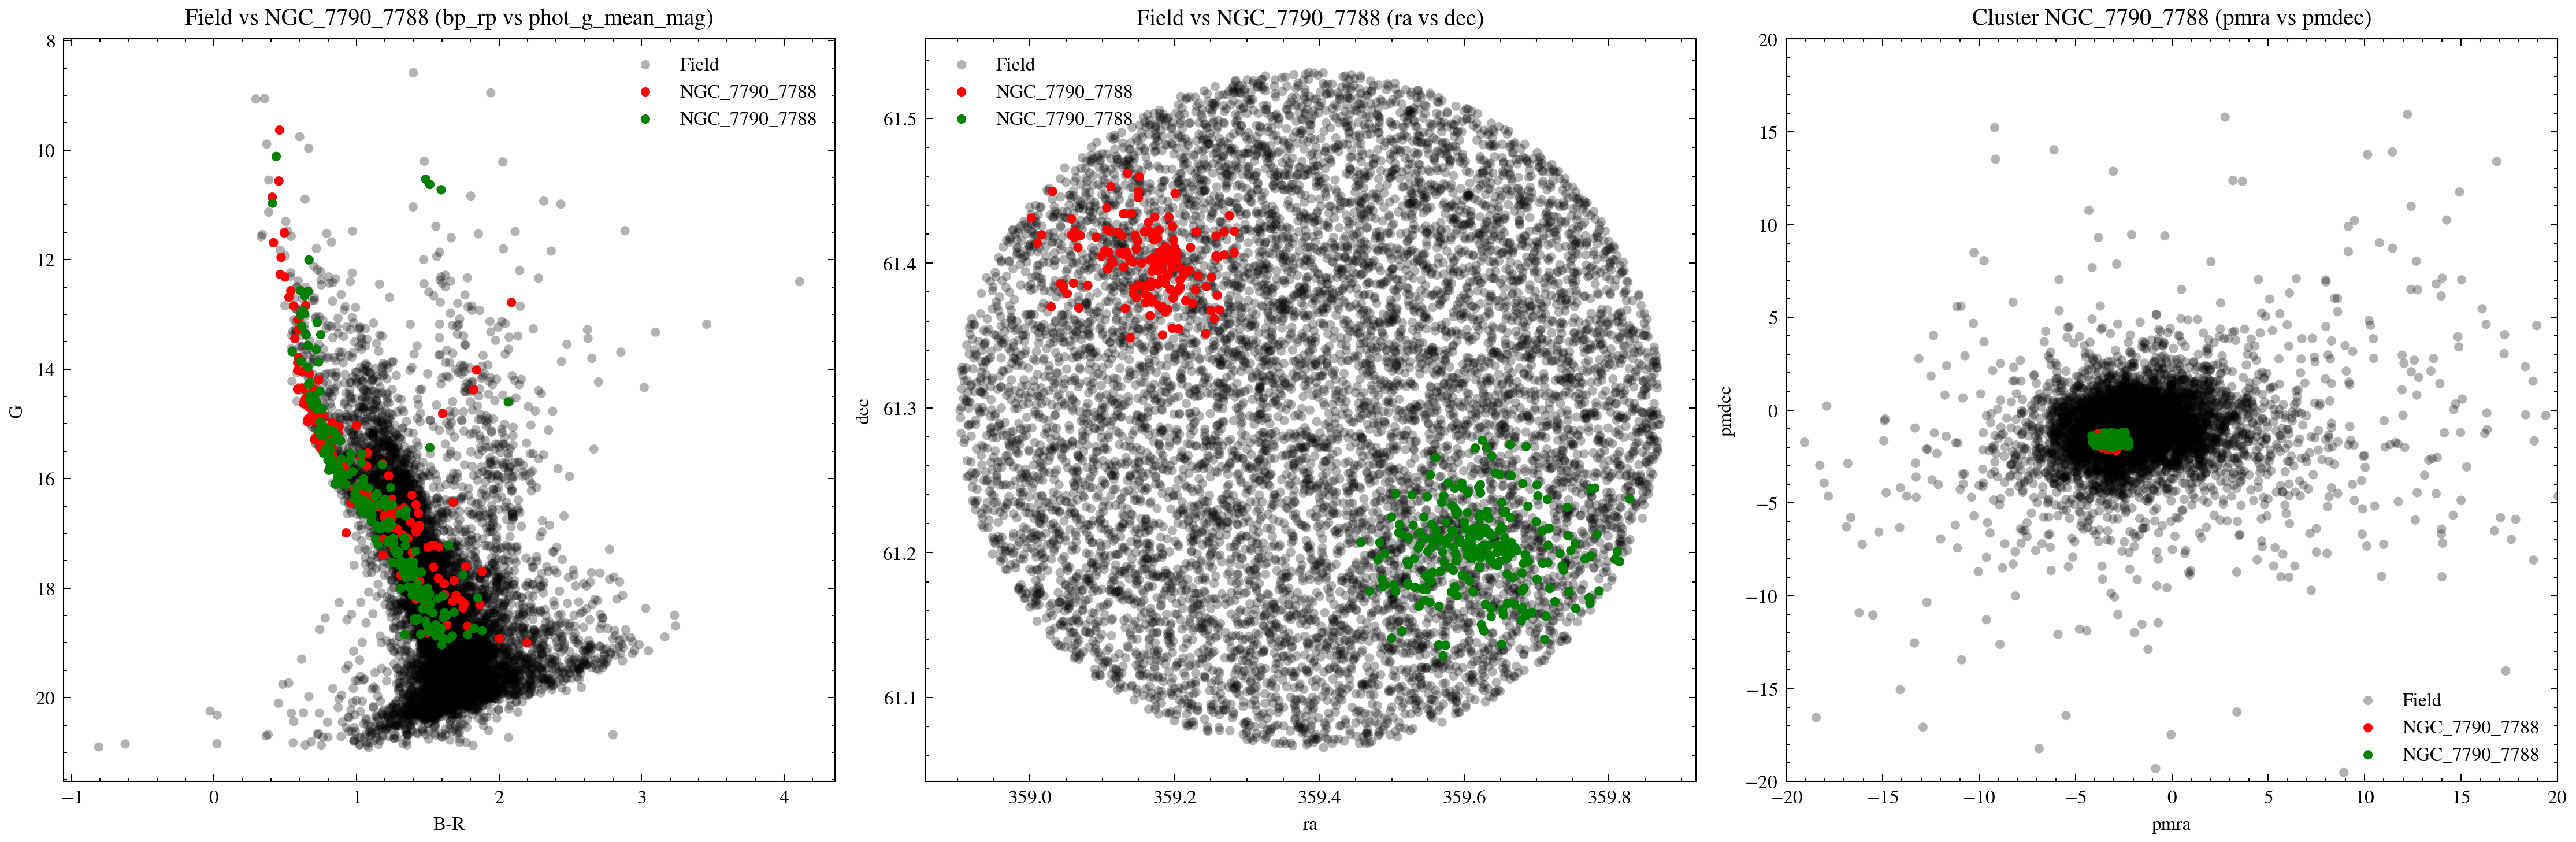

In [59]:
with plt.style.context(['science', 'ieee', 'no-latex']):

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

    # First subplot: bp_rp vs phot_g_mean_mag
    sns.scatterplot(data=df_NGC_7790_7788, x='bp_rp', y='phot_g_mean_mag', s=15, alpha=.3, 
                    color="black", label="Field", ax=axes[0], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster],
                    x='bp_rp', y='phot_g_mean_mag', s=15, alpha=.99, color='red', label="NGC_7790_7788", ax=axes[0], lw=0, edgecolor="none")

    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster+1], 
                    x='bp_rp', y='phot_g_mean_mag', s=15, alpha=.99, color='green', label="NGC_7790_7788", ax=axes[0], lw=0, edgecolor="none")
    axes[0].invert_yaxis()
    axes[0].legend()
    axes[0].set_ylabel("G")
    axes[0].set_xlabel("B-R")
    axes[0].set_title("Field vs NGC_7790_7788 (bp_rp vs phot_g_mean_mag)")

    # Second subplot: ra vs dec
    sns.scatterplot(data=df_NGC_7790_7788, x='ra', y='dec', s=15, alpha=.3, color="black", label="Field", ax=axes[1], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster],
                    x='ra', y='dec', s=15, alpha=.99, color='red', label="NGC_7790_7788", ax=axes[1], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster+1],
                    x='ra', y='dec', s=15, alpha=.99, color='green', label="NGC_7790_7788", ax=axes[1], lw=0, edgecolor="none")
    axes[1].legend()
    axes[1].set_title("Field vs NGC_7790_7788 (ra vs dec)")

    # Third subplot: pmra vs pmdec
    sns.scatterplot(data=df_NGC_7790_7788, 
                    x='pmra', y='pmdec', s=15, alpha=.3, color="black", label="Field", ax=axes[2], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster],
                    x='pmra', y='pmdec', s=15, alpha=.99, color='red', label="NGC_7790_7788", ax=axes[2], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_7790_7788_cluster[df_NGC_7790_7788_cluster['gmm_pred'] == num_cluster+1],
                    x='pmra', y='pmdec', s=15, alpha=.99, color='green', label="NGC_7790_7788", ax=axes[2], lw=0, edgecolor="none")
    axes[2].set_xlim(-20, 20)
    axes[2].set_ylim(-20, 20)
    axes[2].legend()
    axes[2].set_title("Cluster NGC_7790_7788 (pmra vs pmdec)")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(path+"/NGC_7790_7788_field.pdf")
    plt.savefig(path+"/NGC_7790_7788_field.jpg")
    plt.show()

---

### Savings

In [60]:
df_NGC_7790_7788_cluster = df_NGC_7790_7788_cluster.merge(
    df_NGC_7790_7788[["source_id", "ra_error",
             "dec_error", "pmra_error",
             "pmdec_error", "teff_gspphot"]], on='source_id', how='left')

In [61]:
new_cluster["ra_error"], new_cluster["dec_error"], new_cluster["pmra_error"], new_cluster["pmdec_error"], new_cluster["plx_error"] = \
np.mean(df_NGC_7790_7788_cluster["ra_error"]), np.mean(df_NGC_7790_7788_cluster["dec_error"]), np.mean(df_NGC_7790_7788_cluster["pmra_error"]), np.mean(df_NGC_7790_7788_cluster["pmdec_error"]), np.mean(df_NGC_7790_7788_cluster["parallax_error"])

In [62]:
# Check if "NGC_7790_7788" exists in the "Name" column
if "NGC_7790_7788" in Clusters["Name"].values:
    Clusters.loc[Clusters["Name"] == "NGC_7790_7788", ['init_data', 'init_filter', 'mst_cut', 'mst_filter', 'gmm_filter',
        'pmra', 'pmdec', 'ra', 'dec', 'plx', 'prob_80', 'ra_error',
        'dec_error', 'pmra_error', 'pmdec_error', 'plx_error']] = list(new_cluster.values())[1:]
else:
    # Appending a new row using concat instead of append (append is deprecated)
    Clusters = pd.concat([Clusters, pd.DataFrame([new_cluster])], ignore_index=True)

In [63]:
Clusters.to_excel("../Clusters.xlsx")

In [64]:
df_NGC_7790_7788_cluster.to_excel("../MST PAPER DATA/NGC_7790_7788/NGC_7790_7788_members.xlsx")